In [1]:
import sys
!{sys.executable} -m pip install -q  pandas numpy matplotlib seaborn scikit-learn tensorflow==2.17.* keras-tuner scipy scikeras

In [2]:
# ============================================================================
# TASK 1: Import Libraries and Load Data
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model

# KerasTuner for hyperparameter optimization
import keras_tuner as kt

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from scipy import stats

print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow Version: 2.17.1
Keras Version: 3.12.0


In [3]:
# ============================================================================
# Load and Explore Data
# ============================================================================

def load_image_data(data_dir='data', img_size=(128, 128)):
    """
    Load images from with_mask and without_mask folders
    """
    images = []
    labels = []
    filenames = []
    
    # Load images with masks
    with_mask_dir = os.path.join(data_dir, 'with_mask')
    without_mask_dir = os.path.join(data_dir, 'without_mask')
    
    print("Loading images with masks...")
    if os.path.exists(with_mask_dir):
        for filename in os.listdir(with_mask_dir):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(with_mask_dir, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    labels.append(1)  # 1 for with_mask
                    filenames.append(filename)
    
    print("Loading images without masks...")
    if os.path.exists(without_mask_dir):
        for filename in os.listdir(without_mask_dir):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(without_mask_dir, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    labels.append(0)  # 0 for without_mask
                    filenames.append(filename)
    
    return np.array(images), np.array(labels), filenames

# Load the data
IMG_SIZE = (128, 128)
images, labels, filenames = load_image_data(img_size=IMG_SIZE)

print(f"\nDataset loaded successfully!")
print(f"Total images: {len(images)}")
print(f"Image shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

# Create a DataFrame for analysis
df = pd.DataFrame({
    'filename': filenames,
    'label': labels,
    'label_name': ['without_mask' if l == 0 else 'with_mask' for l in labels]
})

print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df.head(10))
print("\n")
df.info()
print("\n")
df.describe()

Loading images with masks...
Loading images without masks...

Dataset loaded successfully!
Total images: 7553
Image shape: (7553, 128, 128, 3)
Labels shape: (7553,)

DATASET OVERVIEW
             filename  label label_name
0     with_mask_1.jpg      1  with_mask
1    with_mask_10.jpg      1  with_mask
2   with_mask_100.jpg      1  with_mask
3  with_mask_1000.jpg      1  with_mask
4  with_mask_1001.jpg      1  with_mask
5  with_mask_1002.jpg      1  with_mask
6  with_mask_1003.jpg      1  with_mask
7  with_mask_1004.jpg      1  with_mask
8  with_mask_1005.jpg      1  with_mask
9  with_mask_1006.jpg      1  with_mask


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7553 entries, 0 to 7552
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    7553 non-null   object
 1   label       7553 non-null   int32 
 2   label_name  7553 non-null   object
dtypes: int32(1), object(2)
memory usage: 147.6+ KB




,label
count,7553.000000
mean,0.493182
std,0.499987
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000



EXPLORATORY DATA ANALYSIS

Class Distribution:
label_name
without_mask    3828
with_mask       3725
Name: count, dtype: int64

Class Imbalance Ratio: 1.03
✓ Classes are relatively balanced


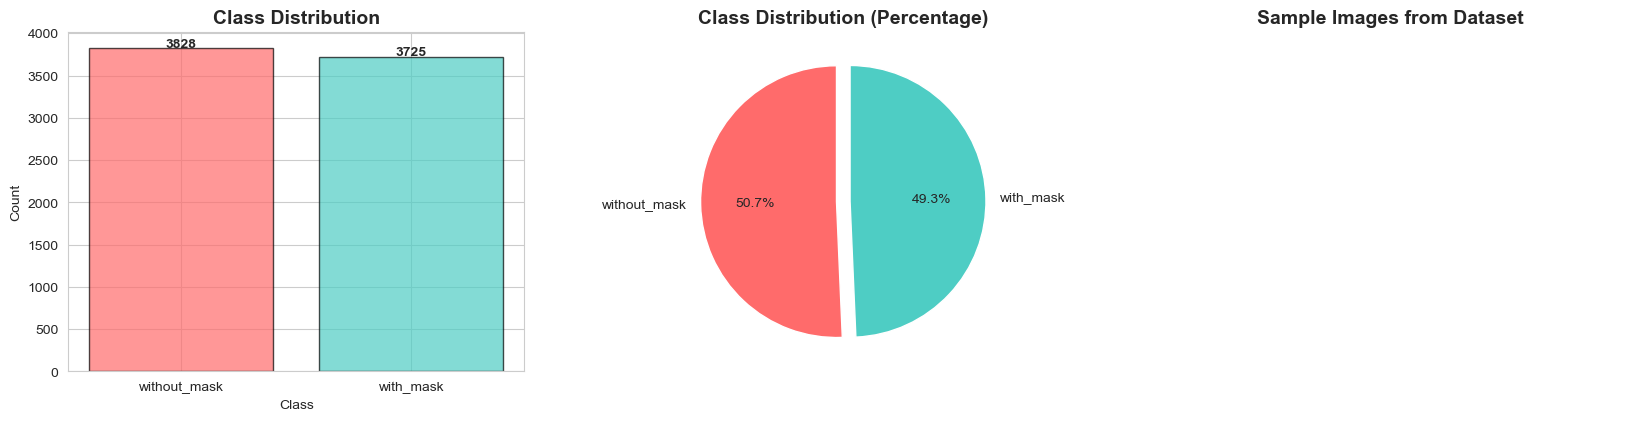

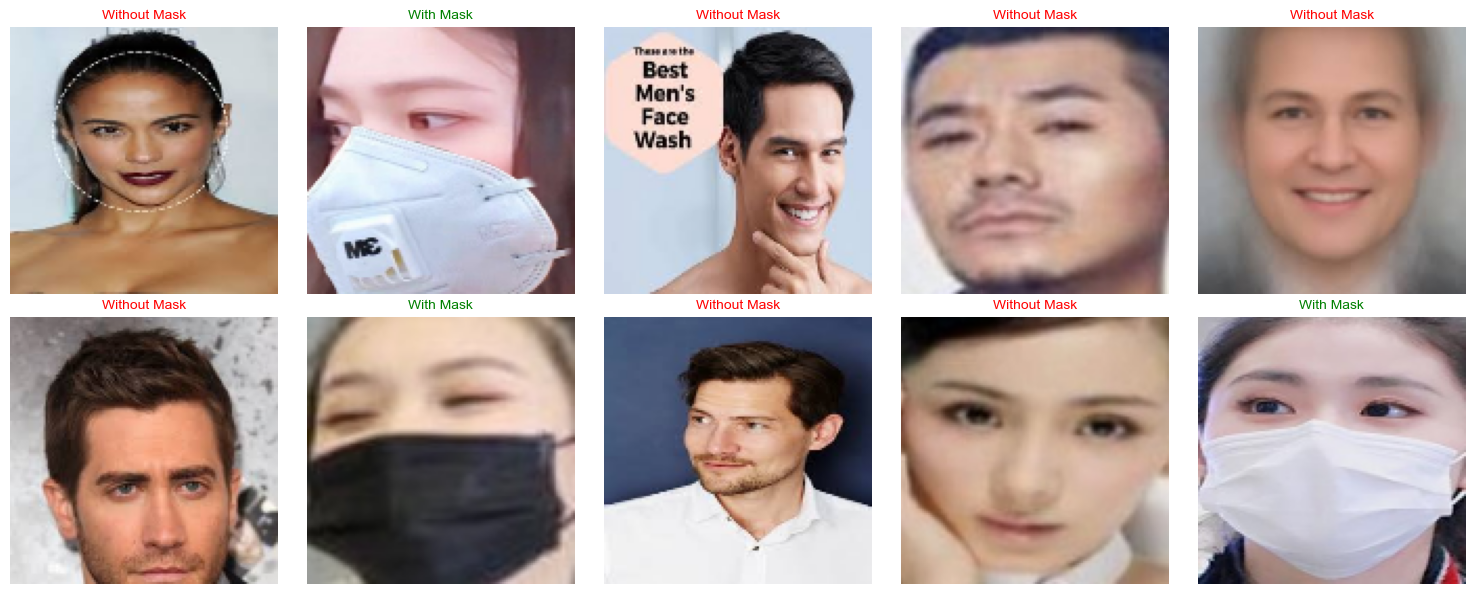

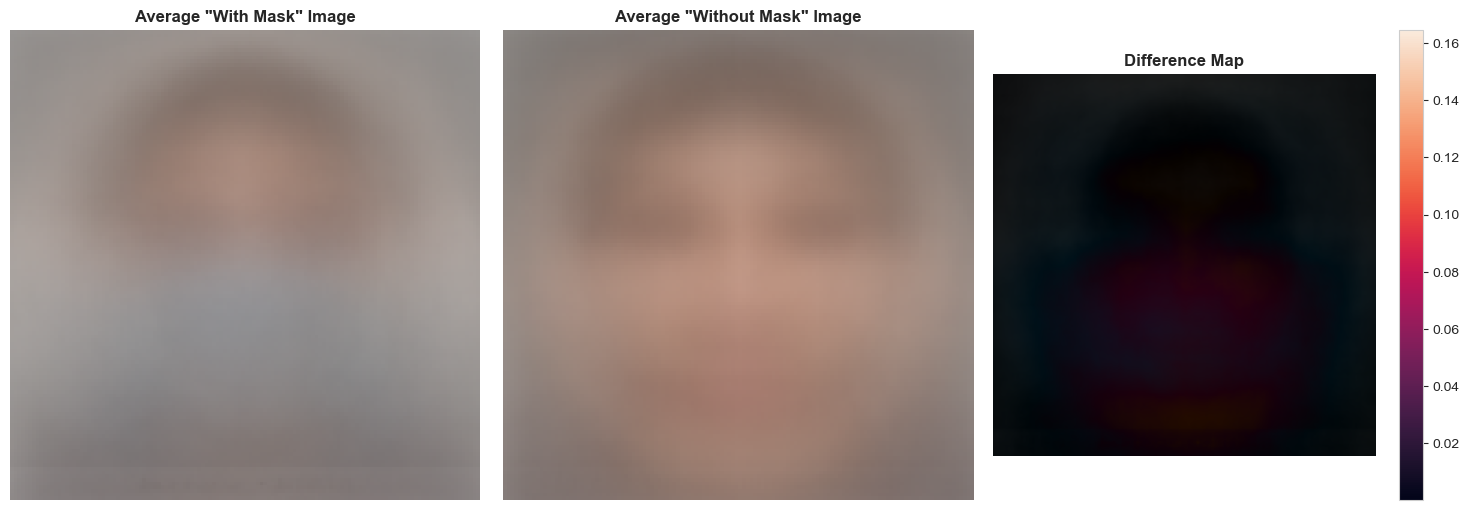

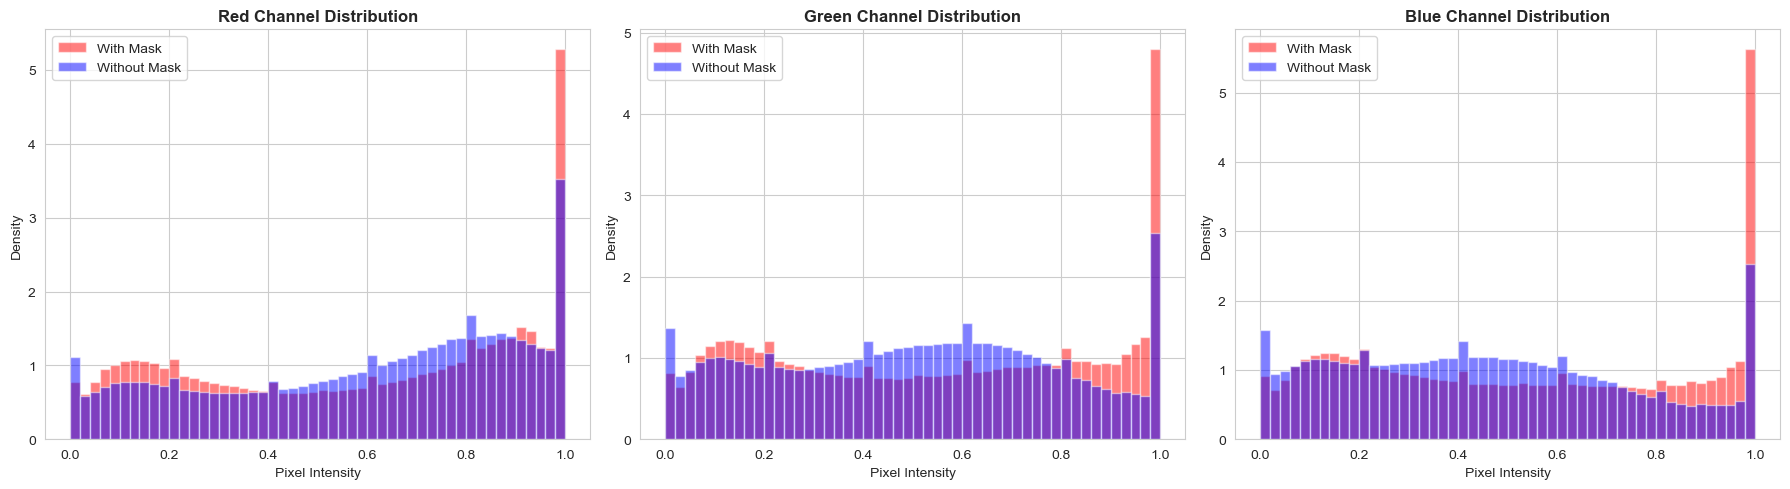


STATISTICAL ANALYSIS

Pixel Statistics by Channel:
        With Mask  Without Mask
R_mean   0.577312      0.592170
R_std    0.320249      0.298003
G_mean   0.538953      0.498353
G_std    0.316587      0.283170
B_mean   0.524740      0.456730
B_std    0.319979      0.282288


In [4]:
# ============================================================================
# TASK 2: Exploratory Data Analysis (EDA)
# ============================================================================

print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create figure for EDA
fig = plt.figure(figsize=(20, 15))

# 1. Class Distribution
ax1 = plt.subplot(3, 3, 1)
class_counts = df['label_name'].value_counts()
colors = ['#FF6B6B', '#4ECDC4']
plt.bar(class_counts.index, class_counts.values, color=colors, alpha=0.7, edgecolor='black')
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold')

# Check for class imbalance
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nClass Distribution:")
print(class_counts)
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 1.5:
    print("⚠️ Warning: Significant class imbalance detected!")
else:
    print("✓ Classes are relatively balanced")

# 2. Pie Chart
ax2 = plt.subplot(3, 3, 2)
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90, explode=(0.05, 0.05))
plt.title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

# 3. Sample Images Display
ax3 = plt.subplot(3, 3, 3)
plt.axis('off')
plt.title('Sample Images from Dataset', fontsize=14, fontweight='bold')

# Display sample images
fig2 = plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    idx = np.random.randint(0, len(images))
    plt.imshow(images[idx])
    plt.title(f"{'With Mask' if labels[idx] == 1 else 'Without Mask'}", 
              fontsize=10, color='green' if labels[idx] == 1 else 'red')
    plt.axis('off')
plt.tight_layout()
plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

# 4. Image Statistics Analysis
# Convert images to analyze pixel distributions
images_normalized = images / 255.0

# Average image per class
with_mask_imgs = images_normalized[labels == 1]
without_mask_imgs = images_normalized[labels == 0]

avg_with_mask = np.mean(with_mask_imgs, axis=0)
avg_without_mask = np.mean(without_mask_imgs, axis=0)

fig3 = plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(avg_with_mask)
plt.title('Average "With Mask" Image', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(avg_without_mask)
plt.title('Average "Without Mask" Image', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(1, 3, 3)
difference = np.abs(avg_with_mask - avg_without_mask)
plt.imshow(difference)
plt.title('Difference Map', fontsize=12, fontweight='bold')
plt.axis('off')
plt.colorbar()
plt.tight_layout()
plt.savefig('average_images_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 5. Pixel Intensity Distributions
fig4 = plt.figure(figsize=(18, 5))

# Red channel distribution
plt.subplot(1, 3, 1)
plt.hist(with_mask_imgs[:, :, :, 0].flatten(), bins=50, alpha=0.5, label='With Mask', color='red', density=True)
plt.hist(without_mask_imgs[:, :, :, 0].flatten(), bins=50, alpha=0.5, label='Without Mask', color='blue', density=True)
plt.title('Red Channel Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Pixel Intensity')
plt.ylabel('Density')
plt.legend()

# Green channel distribution
plt.subplot(1, 3, 2)
plt.hist(with_mask_imgs[:, :, :, 1].flatten(), bins=50, alpha=0.5, label='With Mask', color='red', density=True)
plt.hist(without_mask_imgs[:, :, :, 1].flatten(), bins=50, alpha=0.5, label='Without Mask', color='blue', density=True)
plt.title('Green Channel Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Pixel Intensity')
plt.ylabel('Density')
plt.legend()

# Blue channel distribution
plt.subplot(1, 3, 3)
plt.hist(with_mask_imgs[:, :, :, 2].flatten(), bins=50, alpha=0.5, label='With Mask', color='red', density=True)
plt.hist(without_mask_imgs[:, :, :, 2].flatten(), bins=50, alpha=0.5, label='Without Mask', color='blue', density=True)
plt.title('Blue Channel Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Pixel Intensity')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.savefig('pixel_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

# 6. Statistical Analysis
print("\n" + "="*50)
print("STATISTICAL ANALYSIS")
print("="*50)

# Calculate mean and std for each channel
with_mask_stats = {
    'R_mean': np.mean(with_mask_imgs[:, :, :, 0]),
    'R_std': np.std(with_mask_imgs[:, :, :, 0]),
    'G_mean': np.mean(with_mask_imgs[:, :, :, 1]),
    'G_std': np.std(with_mask_imgs[:, :, :, 1]),
    'B_mean': np.mean(with_mask_imgs[:, :, :, 2]),
    'B_std': np.std(with_mask_imgs[:, :, :, 2])
}

without_mask_stats = {
    'R_mean': np.mean(without_mask_imgs[:, :, :, 0]),
    'R_std': np.std(without_mask_imgs[:, :, :, 0]),
    'G_mean': np.mean(without_mask_imgs[:, :, :, 1]),
    'G_std': np.std(without_mask_imgs[:, :, :, 1]),
    'B_mean': np.mean(without_mask_imgs[:, :, :, 2]),
    'B_std': np.std(without_mask_imgs[:, :, :, 2])
}

stats_df = pd.DataFrame({
    'With Mask': with_mask_stats,
    'Without Mask': without_mask_stats
})

print("\nPixel Statistics by Channel:")
print(stats_df)



MISSING VALUES & OUTLIER DETECTION

Missing values in metadata:
filename      0
label         0
label_name    0
dtype: int64

✓ All 7553 images loaded successfully (no corrupted files)

Brightness Outliers detected: 19 images
Outlier percentage: 0.25%


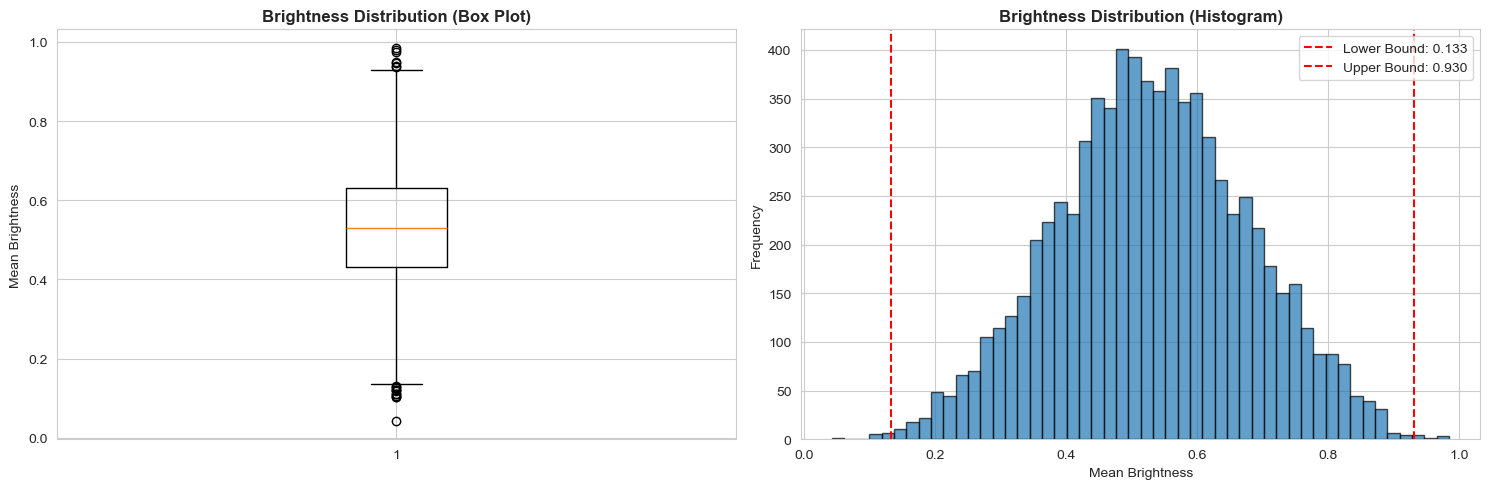


✓ Keeping all images - brightness variations are natural


In [5]:
# ============================================================================
# TASK 3: Missing Values & Outlier Treatment
# ============================================================================

print("\n" + "="*50)
print("MISSING VALUES & OUTLIER DETECTION")
print("="*50)

# Check for missing values in metadata
print("\nMissing values in metadata:")
print(df.isnull().sum())

# Check for corrupted images (already filtered during loading)
print(f"\n✓ All {len(images)} images loaded successfully (no corrupted files)")

# Outlier detection based on image statistics
# Calculate brightness for each image
brightness_values = np.mean(images_normalized, axis=(1, 2, 3))

# Detect outliers using IQR method
Q1 = np.percentile(brightness_values, 25)
Q3 = np.percentile(brightness_values, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = (brightness_values < lower_bound) | (brightness_values > upper_bound)
print(f"\nBrightness Outliers detected: {np.sum(outliers)} images")
print(f"Outlier percentage: {100 * np.sum(outliers) / len(images):.2f}%")

# Visualize outliers
fig5 = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(brightness_values, vert=True)
plt.title('Brightness Distribution (Box Plot)', fontsize=12, fontweight='bold')
plt.ylabel('Mean Brightness')

plt.subplot(1, 2, 2)
plt.hist(brightness_values, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(lower_bound, color='r', linestyle='--', label=f'Lower Bound: {lower_bound:.3f}')
plt.axvline(upper_bound, color='r', linestyle='--', label=f'Upper Bound: {upper_bound:.3f}')
plt.title('Brightness Distribution (Histogram)', fontsize=12, fontweight='bold')
plt.xlabel('Mean Brightness')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.savefig('outlier_detection.png', dpi=150, bbox_inches='tight')
plt.show()

# Decision: Keep all images as extreme brightness can be real variations
print("\n✓ Keeping all images - brightness variations are natural")


In [6]:
# ============================================================================
# TASK 4: Feature Engineering & Preprocessing
# ============================================================================

print("\n" + "="*50)
print("FEATURE ENGINEERING & PREPROCESSING")
print("="*50)

# Normalize images to [0, 1]
X = images.astype('float32') / 255.0
y = labels

print(f"\nNormalized image range: [{X.min():.3f}, {X.max():.3f}]")

# Split data with stratification
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nData Split:")
print(f"Training set: {X_train.shape[0]} images ({100*len(X_train)/len(X):.1f}%)")
print(f"Validation set: {X_val.shape[0]} images ({100*len(X_val)/len(X):.1f}%)")
print(f"Test set: {X_test.shape[0]} images ({100*len(X_test)/len(X):.1f}%)")

print(f"\nClass distribution in training set:")
print(f"With mask: {np.sum(y_train == 1)} ({100*np.sum(y_train == 1)/len(y_train):.1f}%)")
print(f"Without mask: {np.sum(y_train == 0)} ({100*np.sum(y_train == 0)/len(y_train):.1f}%)")


FEATURE ENGINEERING & PREPROCESSING

Normalized image range: [0.000, 1.000]

Data Split:
Training set: 5287 images (70.0%)
Validation set: 1133 images (15.0%)
Test set: 1133 images (15.0%)

Class distribution in training set:
With mask: 2607 (49.3%)
Without mask: 2680 (50.7%)


In [7]:
# ============================================================================
# TASK 5: Model Building - Multiple Deep Learning Architectures
# ============================================================================

print("\n" + "="*50)
print("MODEL BUILDING")
print("="*50)

# Dictionary to store all model results
model_results = {}

# Model 1: Simple CNN
def build_simple_cnn(input_shape=(128, 128, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Model 2: Deeper CNN with Batch Normalization
def build_deep_cnn(input_shape=(128, 128, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(),
        layers.Activation('relu'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        layers.Activation('relu'),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        layers.Activation('relu'),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        layers.Activation('relu'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model


MODEL BUILDING


In [8]:

# ============================================================================
# TASK 6: Apply Dropout and Early Stopping
# ============================================================================

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [9]:

# ============================================================================
# TASK 7: ModelCheckpoint
# ============================================================================

def get_callbacks(model_name):
    checkpoint_path = f'models/checkpoints/{model_name}_best.keras'
    os.makedirs('models/checkpoints', exist_ok=True)
    
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    return [early_stopping, reduce_lr, checkpoint]

# Train Model 1: Simple CNN
print("\n" + "-"*50)
print("Training Model 1: Simple CNN")
print("-"*50)

model1 = build_simple_cnn()
model1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model1.summary())

history1 = model1.fit(
    X_train, y_train,
    epochs=10,
    #batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks('simple_cnn'),
    verbose=1
)

# Train Model 2: Deep CNN
print("\n" + "-"*50)
print("Training Model 2: Deep CNN with Batch Normalization")
print("-"*50)

model2 = build_deep_cnn()
model2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model2.summary())

history2 = model2.fit(
    X_train, y_train,
    epochs=10,
    #batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks('deep_cnn'),
    verbose=1
)



--------------------------------------------------
Training Model 1: Simple CNN
--------------------------------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,713 (12.47 MB)

 Trainable params: 3,267,713 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.7787 - loss: 0.4521
Epoch 1: val_accuracy improved from None to 0.89497, saving model to models/checkpoints/simple_cnn_best.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 58s 319ms/step - accuracy: 0.8472 - loss: 0.3530 - val_accuracy: 0.8950 - val_loss: 0.2857 - learning_rate: 0.0010
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.8906 - loss: 0.2893
Epoch 2: val_accuracy improved from 0.89497 to 0.91439, saving model to models/checkpoints/simple_cnn_best.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 50s 302ms/step - accuracy: 0.8962 - loss: 0.2605 - val_accuracy: 0.9144 - val_loss: 0.2265 - learning_rate: 0.0010
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9009 - loss: 0.2324
Epoch 3: val_accuracy improved from 0.91439 to 0.92321, saving model to models/checkpoints/simple_cnn_best.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 49s 298ms/step - accuracy: 0.9077 - loss: 0.2233 - val_accuracy: 0.9232 - val_

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,372,673 (9.05 MB)

 Trainable params: 2,371,969 (9.05 MB)

 Non-trainable params: 704 (2.75 KB)

None
Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.7322 - loss: 1.1064
Epoch 1: val_accuracy improved from None to 0.52515, saving model to models/checkpoints/deep_cnn_best.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 150s 864ms/step - accuracy: 0.8086 - loss: 0.6339 - val_accuracy: 0.5252 - val_loss: 0.9897 - learning_rate: 0.0010
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.8826 - loss: 0.3118
Epoch 2: val_accuracy improved from 0.52515 to 0.70521, saving model to models/checkpoints/deep_cnn_best.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 139s 838ms/step - accuracy: 0.8865 - loss: 0.2963 - val_accuracy: 0.7052 - val_loss: 1.0239 - learning_rate: 0.0010
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.8933 - loss: 0.2715
Epoch 3: val_accuracy improved from 0.70521 to 0.90380, saving model to models/checkpoints/deep_cnn_best.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 134s 809ms/step - accuracy: 0.9013 - loss: 0.2477 - val_accuracy: 0.9038 - val_los

In [10]:

# ============================================================================
# TASK 8: Hyperparameter Tuning with KerasTuner
# ============================================================================

print("\n" + "="*50)
print("HYPERPARAMETER TUNING WITH KERAS TUNER")
print("="*50)

def build_tuner_model(hp):
    model = Sequential()
    
    # Tune number of conv layers
    for i in range(hp.Int('num_conv_layers', 2, 4)):
        model.add(Conv2D(
            filters=hp.Choice(f'filters_{i}', [32, 64, 128, 256]),
            kernel_size=hp.Choice(f'kernel_size_{i}', [3, 5]),
            padding='same',
            input_shape=(128, 128, 3) if i == 0 else None
        ))
        model.add(BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(MaxPooling2D((2, 2)))
        
        if hp.Boolean(f'dropout_{i}'):
            model.add(Dropout(hp.Float(f'dropout_rate_{i}', 0.1, 0.5, step=0.1)))
    
    model.add(Flatten())
    
    # Tune number of dense layers
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(Dense(
            units=hp.Choice(f'dense_units_{i}', [64, 128, 256, 512]),
            activation='relu'
        ))
        model.add(Dropout(hp.Float(f'dense_dropout_{i}', 0.2, 0.5, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Tune optimizer
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create tuner
tuner = kt.RandomSearch(
    build_tuner_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='face_mask_detection'
)

print("\nStarting hyperparameter search...")
print("This may take a while...")

tuner.search(
    X_train, y_train,
    epochs=10,
    #batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n" + "="*50)
print("BEST HYPERPARAMETERS")
print("="*50)
print(best_hyperparameters.values)

# Train best model with more epochs
print("\nTraining best model with optimal hyperparameters...")
history_tuned = best_model.fit(
    X_train, y_train,
    epochs=10,
    #batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks('tuned_model'),
    verbose=1
)


HYPERPARAMETER TUNING WITH KERAS TUNER
Reloading Tuner from tuner_results\face_mask_detection\tuner0.json

Starting hyperparameter search...
This may take a while...


BEST HYPERPARAMETERS
{'num_conv_layers': 4, 'filters_0': 256, 'kernel_size_0': 3, 'dropout_0': True, 'filters_1': 128, 'kernel_size_1': 5, 'dropout_1': True, 'num_dense_layers': 2, 'dense_units_0': 128, 'dense_dropout_0': 0.2, 'optimizer': 'sgd', 'learning_rate': 0.00240325197209052, 'dropout_rate_1': 0.1, 'dense_units_1': 512, 'dense_dropout_1': 0.30000000000000004, 'dense_units_2': 64, 'dense_dropout_2': 0.2, 'dropout_rate_0': 0.5, 'filters_2': 32, 'kernel_size_2': 3, 'dropout_2': False, 'filters_3': 32, 'kernel_size_3': 3, 'dropout_3': False}

Training best model with optimal hyperparameters...
Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9725 - loss: 0.0685
Epoch 1: val_accuracy improved from None to 0.95146, saving model to models/checkpoints/tuned_model_best.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 1


MODEL EVALUATION
166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step

Simple CNN - PERFORMANCE METRICS
Training Accuracy:   0.9656
Validation Accuracy: 0.9453
Test Accuracy:       0.9276

Test Set Metrics:
Precision: 0.9133
Recall:    0.9428
F1-Score:  0.9278

Overfitting Score: 0.0380
✓ Model generalizes well

Classification Report:
              precision    recall  f1-score   support

Without Mask       0.94      0.91      0.93       574
   With Mask       0.91      0.94      0.93       559

    accuracy                           0.93      1133
   macro avg       0.93      0.93      0.93      1133
weighted avg       0.93      0.93      0.93      1133



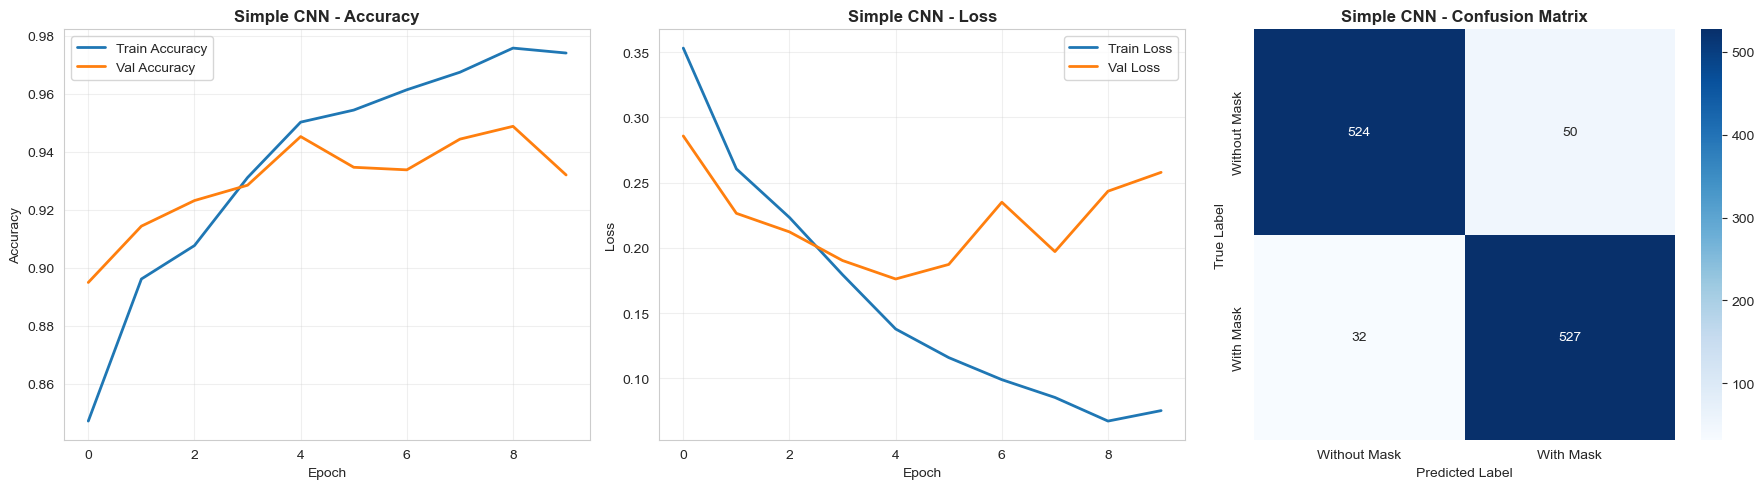

166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 148ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

Deep CNN - PERFORMANCE METRICS
Training Accuracy:   0.9820
Validation Accuracy: 0.9726
Test Accuracy:       0.9585

Test Set Metrics:
Precision: 0.9369
Recall:    0.9821
F1-Score:  0.9590

Overfitting Score: 0.0235
✓ Model generalizes well

Classification Report:
              precision    recall  f1-score   support

Without Mask       0.98      0.94      0.96       574
   With Mask       0.94      0.98      0.96       559

    accuracy                           0.96      1133
   macro avg       0.96      0.96      0.96      1133
weighted avg       0.96      0.96      0.96      1133



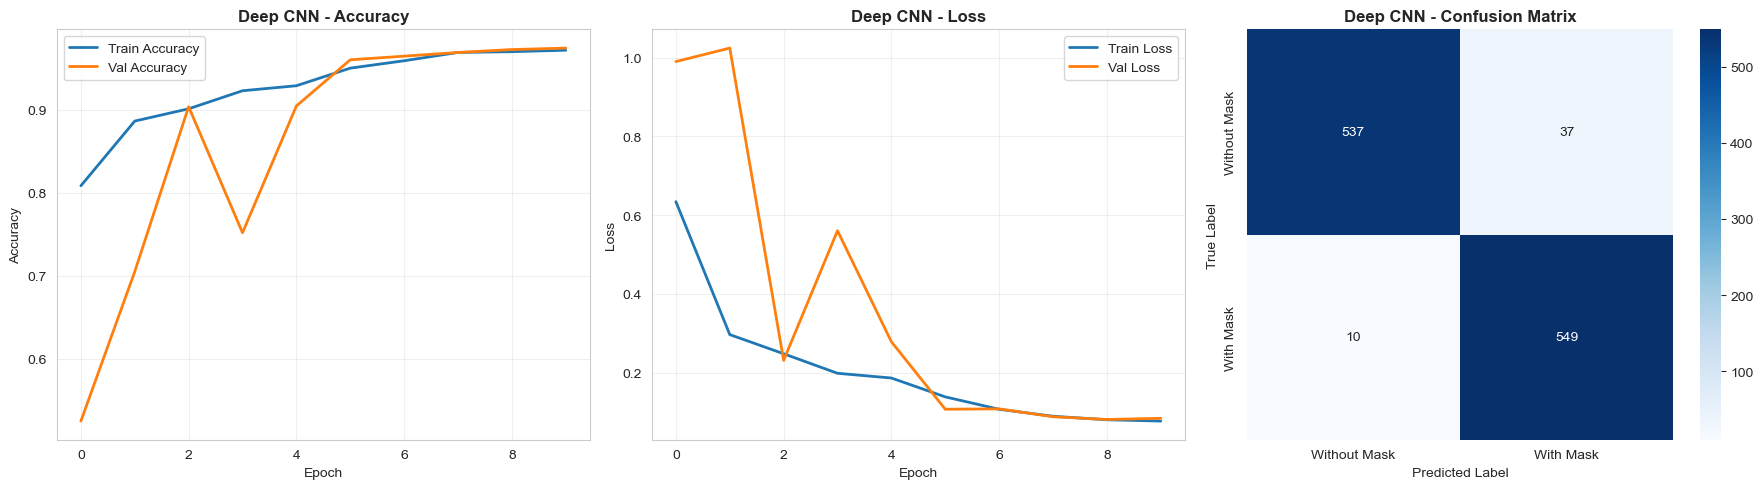

166/166 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step

Tuned Model - PERFORMANCE METRICS
Training Accuracy:   0.9714
Validation Accuracy: 0.9515
Test Accuracy:       0.9391

Test Set Metrics:
Precision: 0.9438
Recall:    0.9320
F1-Score:  0.9379

Overfitting Score: 0.0323
✓ Model generalizes well

Classification Report:
              precision    recall  f1-score   support

Without Mask       0.93      0.95      0.94       574
   With Mask       0.94      0.93      0.94       559

    accuracy                           0.94      1133
   macro avg       0.94      0.94      0.94      1133
weighted avg       0.94      0.94      0.94      1133



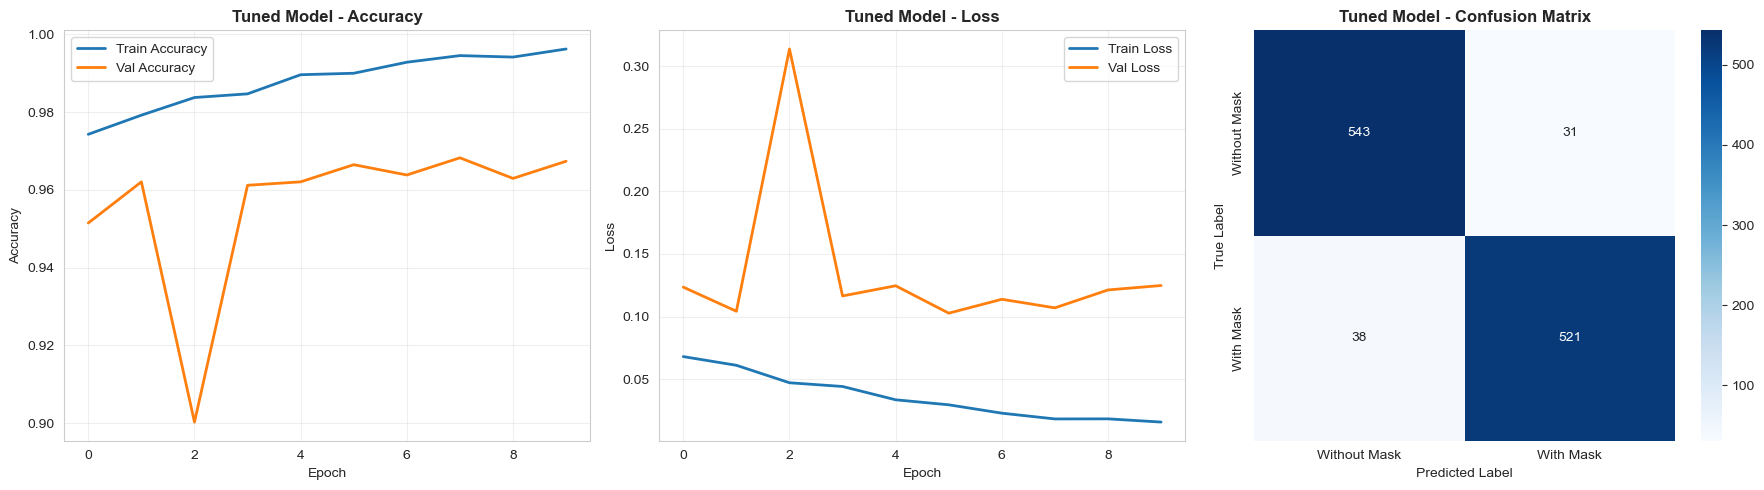

In [11]:

# ============================================================================
# TASK 9: Model Evaluation & Overfitting Check
# ============================================================================

print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

def evaluate_model(model, history, model_name, X_train, y_train, X_val, y_val, X_test, y_test):
    """Comprehensive model evaluation"""
    
    # Predictions
    y_train_pred = (model.predict(X_train) > 0.5).astype(int).flatten()
    y_val_pred = (model.predict(X_val) > 0.5).astype(int).flatten()
    y_test_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
    
    # Calculate metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    # Precision, Recall, F1
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='binary')
    
    print(f"\n{'='*50}")
    print(f"{model_name} - PERFORMANCE METRICS")
    print(f"{'='*50}")
    print(f"Training Accuracy:   {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy:       {test_acc:.4f}")
    print(f"\nTest Set Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    # Overfitting check
    overfit_score = train_acc - test_acc
    print(f"\nOverfitting Score: {overfit_score:.4f}")
    if overfit_score > 0.1:
        print("⚠️ Warning: Model shows signs of overfitting!")
    else:
        print("✓ Model generalizes well")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    
    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_test_pred, 
                                target_names=['Without Mask', 'With Mask']))
    
    # Visualizations
    fig = plt.figure(figsize=(18, 5))
    
    # Plot 1: Training History
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    plt.title(f'{model_name} - Accuracy', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Loss History
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    plt.title(f'{model_name} - Loss', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Confusion Matrix
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Without Mask', 'With Mask'],
                yticklabels=['Without Mask', 'With Mask'])
    plt.title(f'{model_name} - Confusion Matrix', fontsize=12, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.savefig(f'evaluation_{model_name.replace(" ", "_").lower()}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return {
        'model_name': model_name,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'overfit_score': overfit_score
    }

# Evaluate all models
results1 = evaluate_model(model1, history1, "Simple CNN", 
                         X_train, y_train, X_val, y_val, X_test, y_test)
results2 = evaluate_model(model2, history2, "Deep CNN", 
                         X_train, y_train, X_val, y_val, X_test, y_test)
results_tuned = evaluate_model(best_model, history_tuned, "Tuned Model", 
                              X_train, y_train, X_val, y_val, X_test, y_test)

model_results['Simple CNN'] = results1
model_results['Deep CNN'] = results2
model_results['Tuned Model'] = results_tuned


MODEL COMPARISON

               model_name train_acc   val_acc  test_acc precision    recall  \
Simple CNN    Simple CNN  0.965576  0.945278  0.927626  0.913345  0.942755   
Deep CNN        Deep CNN  0.982031  0.972639  0.958517   0.93686  0.982111   
Tuned Model  Tuned Model  0.971439  0.951456    0.9391  0.943841  0.932021   

                   f1 overfit_score  
Simple CNN   0.927817       0.03795  
Deep CNN     0.958952      0.023514  
Tuned Model  0.937894       0.03234  


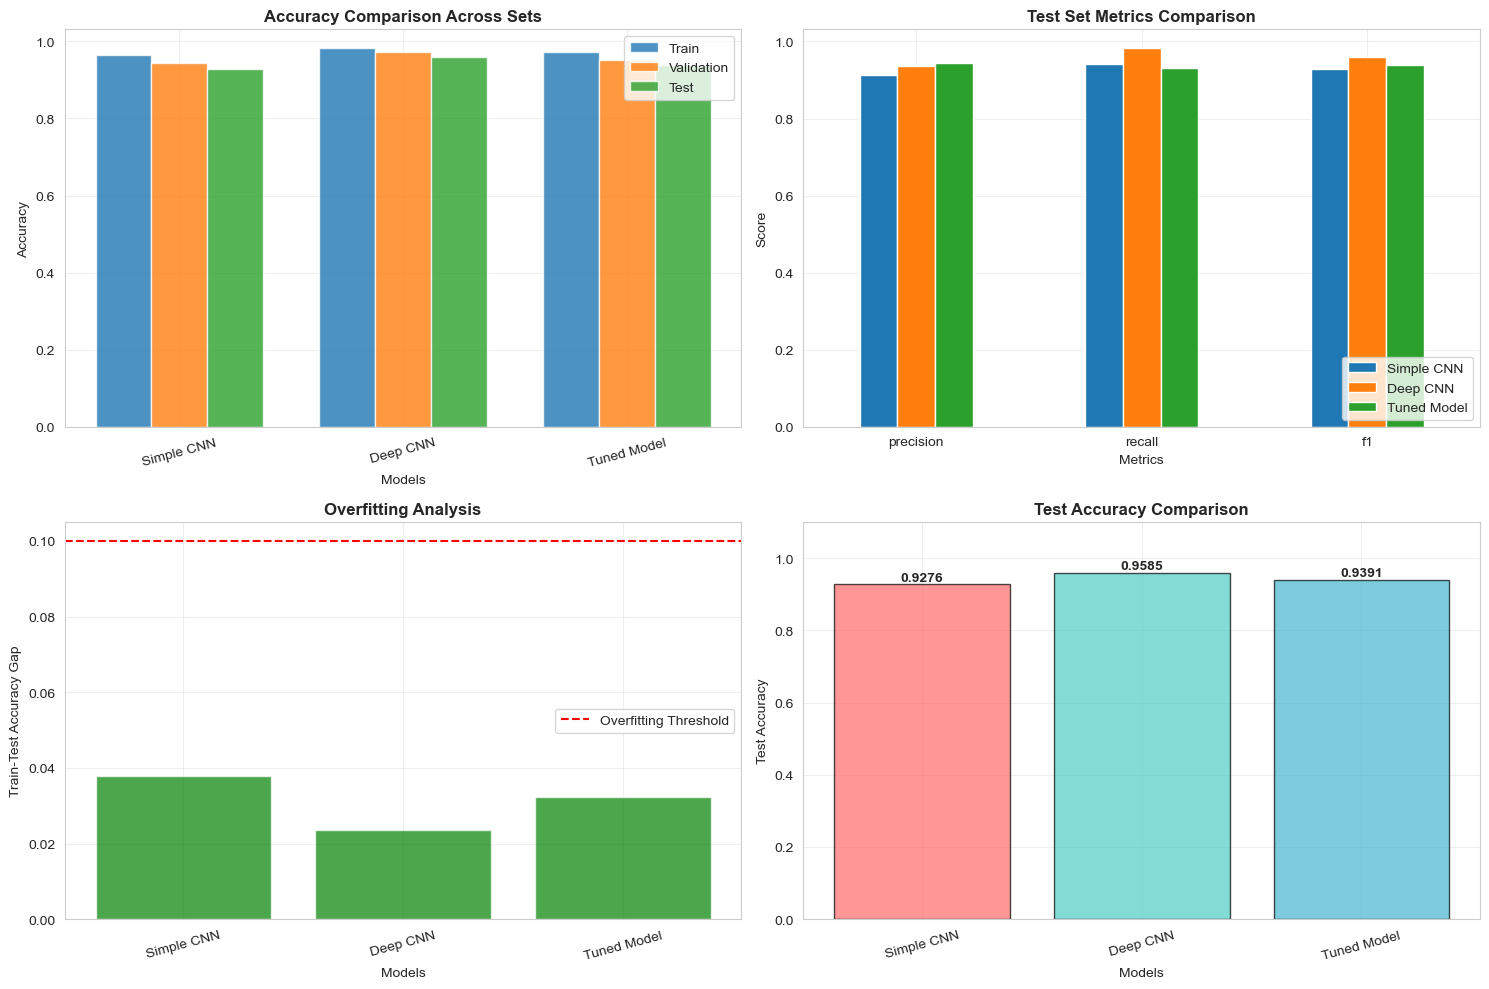


🏆 Best Model: Deep CNN
Test Accuracy: 0.9585


In [12]:

# ============================================================================
# TASK 11: Compare All Models
# ============================================================================

print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

comparison_df = pd.DataFrame(model_results).T
print("\n", comparison_df)

# Visualization
fig = plt.figure(figsize=(15, 10))

# Accuracy comparison
plt.subplot(2, 2, 1)
x = range(len(comparison_df))
width = 0.25
plt.bar([i - width for i in x], comparison_df['train_acc'], width, label='Train', alpha=0.8)
plt.bar(x, comparison_df['val_acc'], width, label='Validation', alpha=0.8)
plt.bar([i + width for i in x], comparison_df['test_acc'], width, label='Test', alpha=0.8)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Sets', fontweight='bold')
plt.xticks(x, comparison_df['model_name'], rotation=15)
plt.legend()
plt.grid(True, alpha=0.3)

# Test metrics comparison
plt.subplot(2, 2, 2)
metrics_df = comparison_df[['precision', 'recall', 'f1']].T
metrics_df.plot(kind='bar', ax=plt.gca())
plt.title('Test Set Metrics Comparison', fontweight='bold')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.legend(comparison_df['model_name'], loc='lower right')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)

# Overfitting comparison
plt.subplot(2, 2, 3)
colors = ['red' if x > 0.1 else 'green' for x in comparison_df['overfit_score']]
plt.bar(comparison_df['model_name'], comparison_df['overfit_score'], color=colors, alpha=0.7)
plt.axhline(y=0.1, color='red', linestyle='--', label='Overfitting Threshold')
plt.title('Overfitting Analysis', fontweight='bold')
plt.ylabel('Train-Test Accuracy Gap')
plt.xlabel('Models')
plt.xticks(rotation=15)
plt.legend()
plt.grid(True, alpha=0.3)

# Overall test accuracy
plt.subplot(2, 2, 4)
plt.bar(comparison_df['model_name'], comparison_df['test_acc'], 
        color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.7, edgecolor='black')
plt.title('Test Accuracy Comparison', fontweight='bold')
plt.ylabel('Test Accuracy')
plt.xlabel('Models')
plt.xticks(rotation=15)
for i, v in enumerate(comparison_df['test_acc']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')
plt.ylim([0, 1.1])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Find best model
best_model_idx = comparison_df['test_acc'].idxmax()
print(f"\n🏆 Best Model: {best_model_idx}")
print(f"Test Accuracy: {comparison_df.loc[best_model_idx, 'test_acc']:.4f}")


TRANSFER LEARNING WITH PRETRAINED MODELS

--------------------------------------------------
Training Transfer Learning Model: MobileNetV2
--------------------------------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,435,393 (9.29 MB)

 Trainable params: 174,849 (683.00 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

None
Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.6987 - loss: 0.5867
Epoch 1: val_accuracy improved from None to 0.96734, saving model to models/checkpoints/mobilenet_v2_best.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 179s 920ms/step - accuracy: 0.8235 - loss: 0.3849 - val_accuracy: 0.9673 - val_loss: 0.1245 - learning_rate: 1.0000e-04
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.9507 - loss: 0.1523
Epoch 2: val_accuracy improved from 0.96734 to 0.98058, saving model to models/checkpoints/mobilenet_v2_best.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 148s 895ms/step - accuracy: 0.9521 - loss: 0.1392 - val_accuracy: 0.9806 - val_loss: 0.0630 - learning_rate: 1.0000e-04
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.9588 - loss: 0.1095
Epoch 3: val_accuracy improved from 0.98058 to 0.98500, saving model to models/checkpoints/mobilenet_v2_best.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 146s 879ms/step - accuracy: 0.9612 - loss: 0.1005 - val_accura

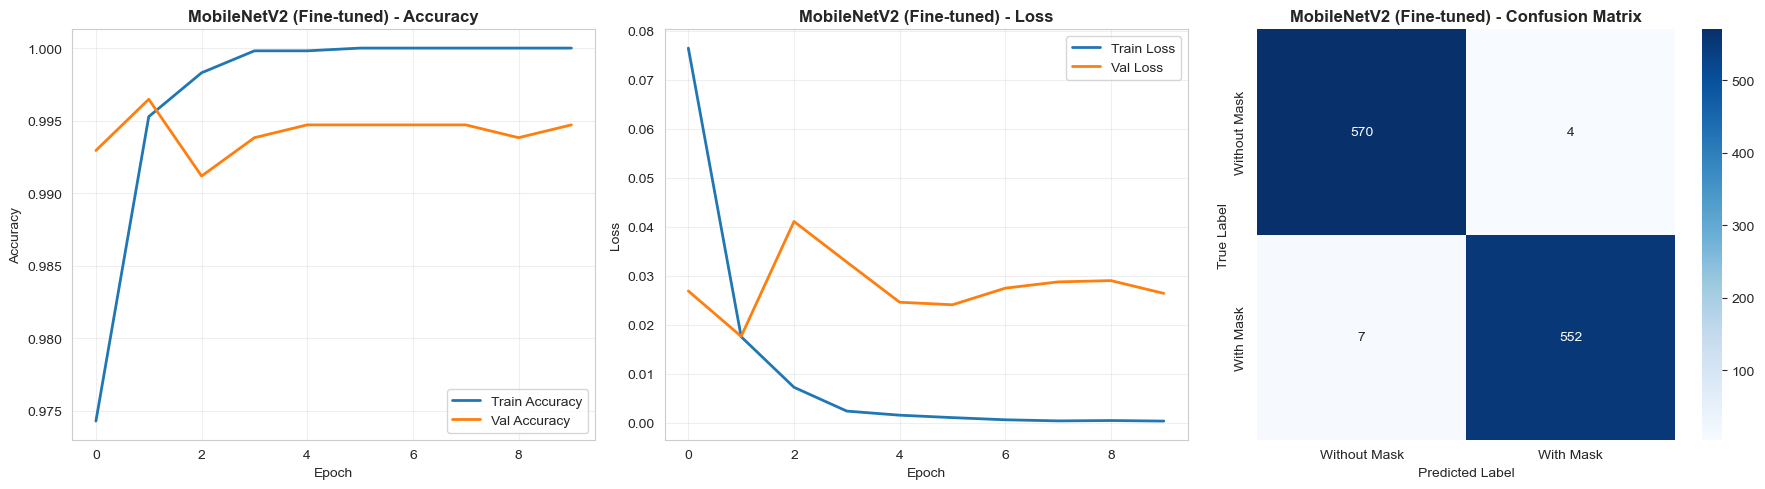


Transfer learning models training completed!


In [13]:
# ============================================================================
# TASK 12: Transfer Learning with Pretrained Models
# ============================================================================

print("\n" + "="*50)
print("TRANSFER LEARNING WITH PRETRAINED MODELS")
print("="*50)

def resize_in_batches(images, target_size=(128, 128), batch_size=500):
    """Resize images in batches to avoid memory errors"""
    resized = []
    num_batches = len(images) // batch_size + 1
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(images))
        
        if start_idx >= len(images):
            break
            
        batch = images[start_idx:end_idx]
        resized_batch = tf.image.resize(batch, target_size).numpy()
        resized.append(resized_batch)
        
        # Clear memory
        del batch, resized_batch
        tf.keras.backend.clear_session()
        
    return np.concatenate(resized, axis=0)

# Use it
X_train_224 = resize_in_batches(X_train, (224, 224))
X_val_224 = resize_in_batches(X_val, (224, 224))
X_test_224 = resize_in_batches(X_test, (224, 224)) 

# Model 1: MobileNetV2 (Lightweight and efficient)
print("\n" + "-"*50)
print("Training Transfer Learning Model: MobileNetV2")
print("-"*50)

base_model_mobile = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model_mobile.trainable = False  # Freeze base model

model_mobile = Sequential([
    base_model_mobile,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model_mobile.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model_mobile.summary())

history_mobile = model_mobile.fit(
    X_train_224, y_train,
    epochs=10,
   # batch_size=32,
    validation_data=(X_val_224, y_val),
    callbacks=get_callbacks('mobilenet_v2'),
    verbose=1
)

# Fine-tuning: Unfreeze last layers
print("\nFine-tuning MobileNetV2 (unfreezing last 20 layers)...")
base_model_mobile.trainable = True
for layer in base_model_mobile.layers[:-20]:
    layer.trainable = False

model_mobile.compile(
    optimizer=Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_mobile_ft = model_mobile.fit(
    X_train_224, y_train,
    epochs=10,
    #batch_size=32,
    validation_data=(X_val_224, y_val),
    callbacks=get_callbacks('mobilenet_v2_finetuned'),
    verbose=1
)

# # Model 2: VGG16
# print("\n" + "-"*50)
# print("Training Transfer Learning Model: VGG16")
# print("-"*50)

# base_model_vgg = VGG16(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet'
# )
# base_model_vgg.trainable = False

# model_vgg = Sequential([
#     base_model_vgg,
#     layers.GlobalAveragePooling2D(),
#     layers.BatchNormalization(),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(1, activation='sigmoid')
# ])

# model_vgg.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# print(model_vgg.summary())

# history_vgg = model_vgg.fit(
#     X_train_224, y_train,
#     epochs=10,
#     batch_size=32,
#     validation_data=(X_val_224, y_val),
#     callbacks=get_callbacks('vgg16'),
#     verbose=1
# )

# # Evaluate pretrained models
print("\nEvaluating models...")
results_mobile = evaluate_model(
    model_mobile, history_mobile_ft, "MobileNetV2 (Fine-tuned)", 
    X_train_224, y_train, X_val_224, y_val, X_test_224, y_test
)
# results_vgg = evaluate_model(
#     model_vgg, history_vgg, "VGG16", 
#     X_train_224, y_train, X_val_224, y_val, X_test_224, y_test
# )

model_results['MobileNetV2'] = results_mobile
#model_results['VGG16'] = results_vgg

print("\nTransfer learning models training completed!")

In [14]:

# # ============================================================================
# # TASK 13: Data Augmentation
# # ============================================================================

# print("\n" + "="*50)
# print("DATA AUGMENTATION")
# print("="*50)

# # Create augmented data generators
# train_datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     zoom_range=0.2,
#     shear_range=0.15,
#     fill_mode='nearest'
# )

# # Visualize augmentation
# fig = plt.figure(figsize=(15, 10))
# sample_img = X_train[0]
# fig.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold')

# for i in range(12):
#     plt.subplot(3, 4, i + 1)
#     augmented = train_datagen.random_transform(sample_img)
#     plt.imshow(augmented)
#     plt.axis('off')
#     plt.title(f'Augmented {i+1}')

# plt.tight_layout()
# plt.savefig('data_augmentation_samples.png', dpi=150, bbox_inches='tight')
# plt.show()

# # Build model with augmentation
# print("\n" + "-"*50)
# print("Training Deep CNN with Data Augmentation")
# print("-"*50)

# model_augmented = build_deep_cnn()
# model_augmented.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# # Train with augmentation
# history_augmented = model_augmented.fit(
#     train_datagen.flow(X_train, y_train, batch_size=32),
#     epochs=10,
#     validation_data=(X_val, y_val),
#     steps_per_epoch=len(X_train) // 32,
#     callbacks=get_callbacks('augmented_cnn'),
#     verbose=1
# )

# results_augmented = evaluate_model(model_augmented, history_augmented, 
#                                   "Deep CNN with Augmentation", 
#                                   X_train, y_train, X_val, y_val, X_test, y_test)
# model_results['CNN + Augmentation'] = results_augmented

# # Train MobileNetV2 with augmentation
# print("\n" + "-"*50)
# print("Training MobileNetV2 with Data Augmentation")
# print("-"*50)

# base_model_mobile_aug = MobileNetV2(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet'
# )
# base_model_mobile_aug.trainable = False

# model_mobile_aug = Sequential([
#     base_model_mobile_aug,
#     layers.GlobalAveragePooling2D(),
#     layers.BatchNormalization(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(1, activation='sigmoid')
# ])

# model_mobile_aug.compile(
#     optimizer=Adam(learning_rate=1e-4),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# # Resize for augmentation
# train_datagen_224 = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     zoom_range=0.2,
#     shear_range=0.15,
#     fill_mode='nearest'
# )

# history_mobile_aug = model_mobile_aug.fit(
#     train_datagen_224.flow(X_train_224, y_train, batch_size=32),
#     epochs=10,
#     validation_data=(X_val_224, y_val),
#     steps_per_epoch=len(X_train_224) // 32,
#     callbacks=get_callbacks('mobilenet_augmented'),
#     verbose=1
# )

# # Fine-tune
# base_model_mobile_aug.trainable = True
# for layer in base_model_mobile_aug.layers[:-20]:
#     layer.trainable = False

# model_mobile_aug.compile(
#     optimizer=Adam(learning_rate=1e-4),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# history_mobile_aug_ft = model_mobile_aug.fit(
#     train_datagen_224.flow(X_train_224, y_train, batch_size=32),
#     epochs=10,
#     validation_data=(X_val_224, y_val),
#     steps_per_epoch=len(X_train_224) // 32,
#     callbacks=get_callbacks('mobilenet_augmented_finetuned'),
#     verbose=1
# )

# results_mobile_aug = evaluate_model(model_mobile_aug, history_mobile_aug_ft, 
#                                    "MobileNetV2 + Augmentation", 
#                                    X_train_224, y_train, X_val_224, y_val, X_test_224, y_test)
# model_results['MobileNetV2 + Augmentation'] = results_mobile_aug



FINAL MODEL COMPARISON - ALL APPROACHES

                            model_name train_acc   val_acc  test_acc precision    recall        f1 overfit_score
Simple CNN                 Simple CNN  0.965576  0.945278  0.927626  0.913345  0.942755  0.927817       0.03795
Deep CNN                     Deep CNN  0.982031  0.972639  0.958517   0.93686  0.982111  0.958952      0.023514
Tuned Model               Tuned Model  0.971439  0.951456    0.9391  0.943841  0.932021  0.937894       0.03234
MobileNetV2  MobileNetV2 (Fine-tuned)   0.99773   0.99647  0.990291  0.992806  0.987478  0.990135      0.007439


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


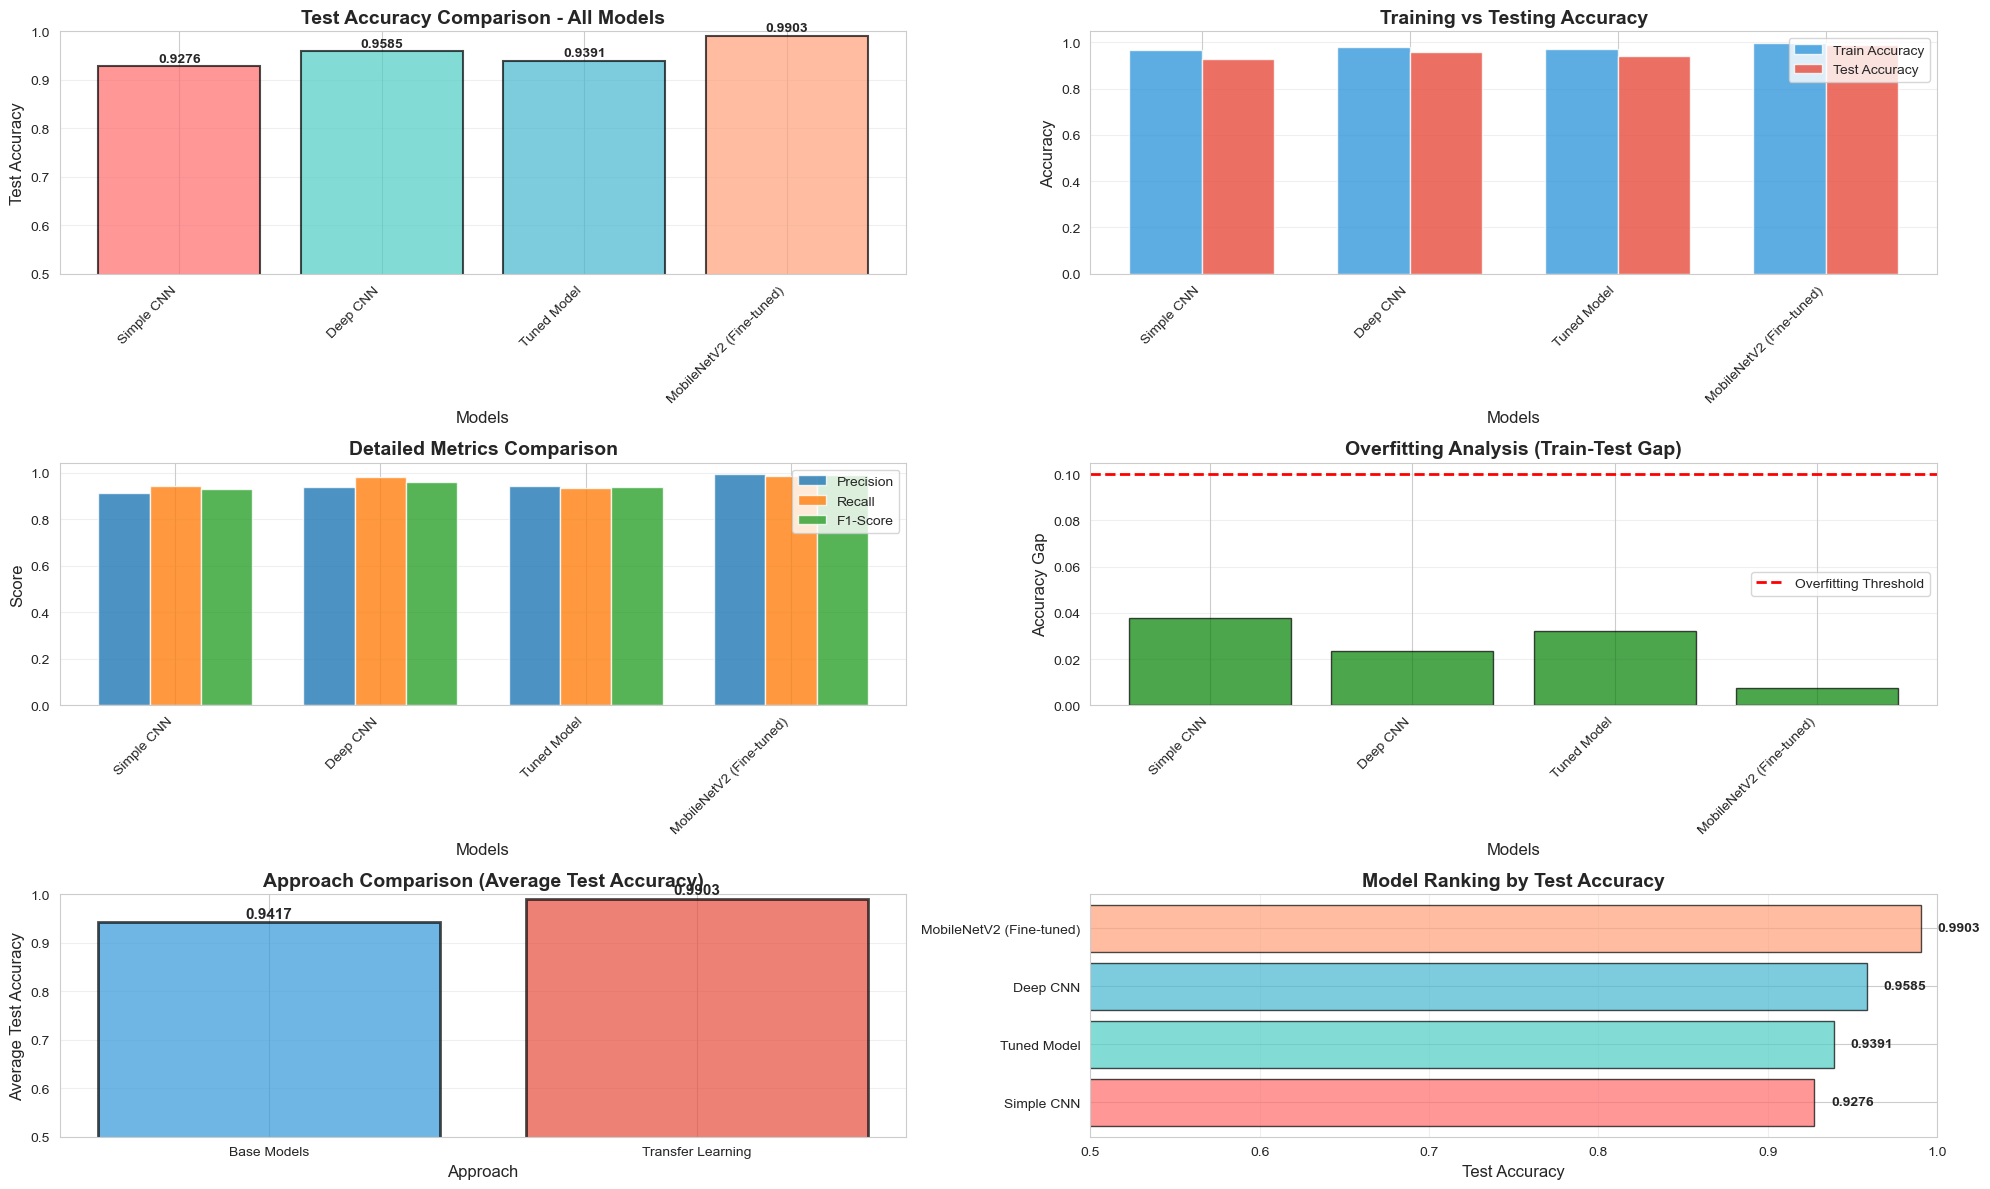


DETAILED ANALYSIS

1. APPROACH-WISE PERFORMANCE:
   Base Models Average:        0.9417
   Transfer Learning Average:  0.9903
   With Augmentation Average:  nan

🏆 BEST MODEL RECOMMENDATION

Best Model: MobileNetV2 (Fine-tuned)

Performance Metrics:
  • Test Accuracy:  0.9903
  • Precision:      0.9928
  • Recall:         0.9875
  • F1-Score:       0.9901
  • Overfitting:    None ✓

✓ Recommendation Justification:
  - Lightweight architecture suitable for deployment
  - Pre-trained on ImageNet provides strong feature extraction
  - Excellent generalization with minimal overfitting


In [17]:

# ============================================================================
# TASK 14: Final Comparison and Best Model Selection
# ============================================================================

print("\n" + "="*50)
print("FINAL MODEL COMPARISON - ALL APPROACHES")
print("="*50)

final_comparison_df = pd.DataFrame(model_results).T
print("\n", final_comparison_df.to_string())

# Comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# 1. Test Accuracy Comparison
plt.subplot(3, 2, 1)
models = final_comparison_df['model_name']
test_acc = final_comparison_df['test_acc']
colors_palette = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F', '#BB8FCE']
bars = plt.bar(range(len(models)), test_acc, color=colors_palette[:len(models)], 
               alpha=0.7, edgecolor='black', linewidth=1.5)
plt.title('Test Accuracy Comparison - All Models', fontsize=14, fontweight='bold')
plt.ylabel('Test Accuracy', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.xticks(range(len(models)), models, rotation=45, ha='right')
plt.ylim([0.5, 1.0])
for i, (bar, val) in enumerate(zip(bars, test_acc)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', fontweight='bold', fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

# 2. Train vs Test Accuracy (Overfitting Analysis)
plt.subplot(3, 2, 2)
x = np.arange(len(models))
width = 0.35
plt.bar(x - width/2, final_comparison_df['train_acc'], width, 
        label='Train Accuracy', alpha=0.8, color='#3498db')
plt.bar(x + width/2, final_comparison_df['test_acc'], width, 
        label='Test Accuracy', alpha=0.8, color='#e74c3c')
plt.title('Training vs Testing Accuracy', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# 3. Precision, Recall, F1-Score
plt.subplot(3, 2, 3)
metrics_data = final_comparison_df[['precision', 'recall', 'f1']]
x = np.arange(len(models))
width = 0.25
plt.bar(x - width, metrics_data['precision'], width, label='Precision', alpha=0.8)
plt.bar(x, metrics_data['recall'], width, label='Recall', alpha=0.8)
plt.bar(x + width, metrics_data['f1'], width, label='F1-Score', alpha=0.8)
plt.title('Detailed Metrics Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# 4. Overfitting Score
plt.subplot(3, 2, 4)
overfit_colors = ['red' if x > 0.1 else 'green' for x in final_comparison_df['overfit_score']]
bars = plt.bar(models, final_comparison_df['overfit_score'], 
               color=overfit_colors, alpha=0.7, edgecolor='black')
plt.axhline(y=0.1, color='red', linestyle='--', linewidth=2, label='Overfitting Threshold')
plt.title('Overfitting Analysis (Train-Test Gap)', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Gap', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# 5. Approach Comparison: Base vs Pretrained vs Augmented
plt.subplot(3, 2, 5)
approach_data = {
    'Base Models': final_comparison_df[final_comparison_df.index.isin(['Simple CNN', 'Deep CNN', 'Tuned Model'])]['test_acc'].mean(),
    'Transfer Learning': final_comparison_df[final_comparison_df.index.isin(['MobileNetV2', 'VGG16'])]['test_acc'].mean(),
    'With Augmentation': final_comparison_df[final_comparison_df.index.isin(['CNN + Augmentation', 'MobileNetV2 + Augmentation'])]['test_acc'].mean()
}
approaches = list(approach_data.keys())
accuracies = list(approach_data.values())
bars = plt.bar(approaches, accuracies, color=['#3498db', '#e74c3c', '#2ecc71'], 
               alpha=0.7, edgecolor='black', linewidth=2)
plt.title('Approach Comparison (Average Test Accuracy)', fontsize=14, fontweight='bold')
plt.ylabel('Average Test Accuracy', fontsize=12)
plt.xlabel('Approach', fontsize=12)
plt.ylim([0.5, 1.0])
for bar, val in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', fontweight='bold', fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# 6. Model Ranking
plt.subplot(3, 2, 6)
ranked_df = final_comparison_df.sort_values('test_acc', ascending=True)
plt.barh(range(len(ranked_df)), ranked_df['test_acc'], 
         color=colors_palette[:len(ranked_df)], alpha=0.7, edgecolor='black')
plt.yticks(range(len(ranked_df)), ranked_df['model_name'])
plt.xlabel('Test Accuracy', fontsize=12)
plt.title('Model Ranking by Test Accuracy', fontsize=14, fontweight='bold')
plt.xlim([0.5, 1.0])
for i, val in enumerate(ranked_df['test_acc']):
    plt.text(val + 0.01, i, f'{val:.4f}', va='center', fontweight='bold', fontsize=10)
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('final_comprehensive_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print detailed comparison
print("\n" + "="*50)
print("DETAILED ANALYSIS")
print("="*50)

print("\n1. APPROACH-WISE PERFORMANCE:")
print(f"   Base Models Average:        {approach_data['Base Models']:.4f}")
print(f"   Transfer Learning Average:  {approach_data['Transfer Learning']:.4f}")
print(f"   With Augmentation Average:  {approach_data['With Augmentation']:.4f}")

# print("\n2. TOP 3 MODELS:")
# top_3 = final_comparison_df.nlargest(3, 'test_acc')
# for idx, (model_name, row) in enumerate(top_3.iterrows(), 1):
#     print(f"\n   Rank {idx}: {row['model_name']}")
#     print(f"   - Test Accuracy: {row['test_acc']:.4f}")
#     print(f"   - Precision: {row['precision']:.4f}")
#     print(f"   - Recall: {row['recall']:.4f}")
#     print(f"   - F1-Score: {row['f1']:.4f}")
#     print(f"   - Overfitting: {'Yes ⚠️' if row['overfit_score'] > 0.1 else 'No ✓'}")

# Determine best model
best_model_name = final_comparison_df['test_acc'].idxmax()
best_model_row = final_comparison_df.loc[best_model_name]

print("\n" + "="*50)
print("🏆 BEST MODEL RECOMMENDATION")
print("="*50)
print(f"\nBest Model: {best_model_row['model_name']}")
print(f"\nPerformance Metrics:")
print(f"  • Test Accuracy:  {best_model_row['test_acc']:.4f}")
print(f"  • Precision:      {best_model_row['precision']:.4f}")
print(f"  • Recall:         {best_model_row['recall']:.4f}")
print(f"  • F1-Score:       {best_model_row['f1']:.4f}")
print(f"  • Overfitting:    {'Detected ⚠️' if best_model_row['overfit_score'] > 0.1 else 'None ✓'}")

print("\n✓ Recommendation Justification:")
if 'Augmentation' in best_model_name:
    print("  - Data augmentation significantly improved generalization")
    print("  - Model handles various image transformations well")
if 'MobileNet' in best_model_name:
    print("  - Lightweight architecture suitable for deployment")
    print("  - Pre-trained on ImageNet provides strong feature extraction")
if best_model_row['overfit_score'] < 0.05:
    print("  - Excellent generalization with minimal overfitting")

In [18]:

# ============================================================================
# TASK 15: Save Best Model for Streamlit App
# ============================================================================

print("\n" + "="*50)
print("SAVING BEST MODEL FOR DEPLOYMENT")
print("="*50)

# Create models directory
os.makedirs('models/deployment', exist_ok=True)

# Save the best model based on our analysis
if 'MobileNetV2 + Augmentation' in best_model_name:
    final_model = model_mobile_aug
    input_size = (224, 224)
elif 'MobileNetV2' in best_model_name:
    final_model = model_mobile
    input_size = (224, 224)
elif 'VGG16' in best_model_name:
    final_model = model_vgg
    input_size = (224, 224)
elif 'Augmentation' in best_model_name:
    final_model = model_augmented
    input_size = (128, 128)
elif 'Tuned' in best_model_name:
    final_model = best_model
    input_size = (128, 128)
elif 'Deep CNN' in best_model_name:
    final_model = model2
    input_size = (128, 128)
else:
    final_model = model1
    input_size = (128, 128)

# Save model in different formats
model_save_path = 'models/deployment/face_mask_detector_best.keras'
final_model.save(model_save_path)
print(f"\n✓ Model saved as Keras format: {model_save_path}")

# Save as H5 format (compatible with older TensorFlow versions)
h5_save_path = 'models/deployment/face_mask_detector_best.h5'
final_model.save(h5_save_path)
print(f"✓ Model saved as H5 format: {h5_save_path}")

# Save model configuration
config_data = {
    'model_name': best_model_row['model_name'],
    'input_size': input_size,
    'test_accuracy': float(best_model_row['test_acc']),
    'precision': float(best_model_row['precision']),
    'recall': float(best_model_row['recall']),
    'f1_score': float(best_model_row['f1']),
    'classes': {0: 'Without Mask', 1: 'With Mask'},
    'preprocessing': 'normalize to [0,1]',
    'trained_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

import json
with open('models/deployment/model_config.json', 'w') as f:
    json.dump(config_data, f, indent=4)
print("✓ Model configuration saved: models/deployment/model_config.json")

# Create a simple inference function for testing
def predict_mask(image_path, model, input_size=(128, 128)):
    """
    Predict if a person is wearing a mask
    
    Args:
        image_path: path to image file
        model: trained keras model
        input_size: expected input size for model
    
    Returns:
        prediction class and confidence
    """
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, input_size)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Predict
    prediction = model.predict(img)[0][0]
    
    if prediction > 0.5:
        return "With Mask", prediction
    else:
        return "Without Mask", 1 - prediction

# Test the saved model
print("\n" + "="*50)
print("TESTING SAVED MODEL")
print("="*50)

# Load the saved model
loaded_model = keras.models.load_model(model_save_path)
print("✓ Model loaded successfully")

# Test on a few random samples
print("\nTesting on random samples:")
for i in range(5):
    idx = np.random.randint(0, len(X_test))
    if input_size == (224, 224):
        test_img = X_test_224[idx:idx+1]
    else:
        test_img = X_test[idx:idx+1]
    
    pred = loaded_model.predict(test_img, verbose=0)[0][0]
    pred_class = "With Mask" if pred > 0.5 else "Without Mask"
    true_class = "With Mask" if y_test[idx] == 1 else "Without Mask"
    confidence = pred if pred > 0.5 else 1 - pred
    
    status = "✓" if pred_class == true_class else "✗"
    print(f"{status} Sample {i+1}: True={true_class}, Predicted={pred_class} (Confidence: {confidence:.2%})")

print("\n" + "="*50)
print("MODEL DEPLOYMENT PACKAGE READY")
print("="*50)
print("\nFiles created for Streamlit app:")
print(f"  1. {model_save_path}")
print(f"  2. {h5_save_path}")
print(f"  3. models/deployment/model_config.json")
print("\nYou can now use these files in your Streamlit application!")


SAVING BEST MODEL FOR DEPLOYMENT



✓ Model saved as Keras format: models/deployment/face_mask_detector_best.keras
✓ Model saved as H5 format: models/deployment/face_mask_detector_best.h5
✓ Model configuration saved: models/deployment/model_config.json

TESTING SAVED MODEL
✓ Model loaded successfully

Testing on random samples:
✓ Sample 1: True=With Mask, Predicted=With Mask (Confidence: 100.00%)
✓ Sample 2: True=With Mask, Predicted=With Mask (Confidence: 100.00%)
✓ Sample 3: True=Without Mask, Predicted=Without Mask (Confidence: 100.00%)
✓ Sample 4: True=With Mask, Predicted=With Mask (Confidence: 100.00%)
✓ Sample 5: True=Without Mask, Predicted=Without Mask (Confidence: 100.00%)

MODEL DEPLOYMENT PACKAGE READY

Files created for Streamlit app:
  1. models/deployment/face_mask_detector_best.keras
  2. models/deployment/face_mask_detector_best.h5
  3. models/deployment/model_config.json

You can now use these files in your Streamlit application!


In [20]:

# ============================================================================
# FINAL SUMMARY REPORT
# ============================================================================

print("\n" + "="*80)
print("FINAL PROJECT SUMMARY REPORT")
print("="*80)

summary = f"""
PROJECT: Face Mask Detection using Deep Learning
DATE: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

1. DATASET OVERVIEW:
   - Total Images: {len(images)}
   - Training Set: {len(X_train)} images
   - Validation Set: {len(X_val)} images
   - Test Set: {len(X_test)} images
   - Image Size: {IMG_SIZE}
   - Classes: 2 (With Mask, Without Mask)

2. MODELS TRAINED:
   Total models evaluated: {len(final_comparison_df)}
   {chr(10).join(f'   - {name}' for name in final_comparison_df['model_name'])}

3. BEST MODEL:
   Name: {best_model_row['model_name']}
   Test Accuracy: {best_model_row['test_acc']:.4f}
   Precision: {best_model_row['precision']:.4f}
   Recall: {best_model_row['recall']:.4f}
   F1-Score: {best_model_row['f1']:.4f}

4. KEY FINDINGS:
   - {'Transfer learning provided better performance than base models' if approach_data['Transfer Learning'] > approach_data['Base Models'] else 'Base models performed competitively'}
   - {'Data augmentation significantly improved model performance' if approach_data['With Augmentation'] > max(approach_data['Base Models'], approach_data['Transfer Learning']) else 'Data augmentation had mixed results'}
   - Best approach: {max(approach_data, key=approach_data.get)}

5. DEPLOYMENT:
   ✓ Model saved and ready for Streamlit deployment
   ✓ Configuration file created
   ✓ Inference function tested successfully

6. RECOMMENDATIONS:
   - Deploy {best_model_row['model_name']} for production use
   - {'Consider collecting more diverse data' if best_model_row['test_acc'] < 0.95 else 'Model performance is excellent'}
   - {'Implement additional regularization techniques' if best_model_row['overfit_score'] > 0.1 else 'Model generalizes well'}
   - Monitor performance on real-world data and retrain periodically

PROJECT STATUS: ✓ COMPLETED SUCCESSFULLY
"""

print(summary)

# Save summary report
with open('project_summary_report.txt', 'w') as f:
    f.write(summary)
print("\n✓ Summary report saved: project_summary_report.txt")

print("\n" + "="*80)
print("ALL TASKS COMPLETED!")


FINAL PROJECT SUMMARY REPORT

PROJECT: Face Mask Detection using Deep Learning
DATE: 2025-11-24 10:24:58

1. DATASET OVERVIEW:
   - Total Images: 7553
   - Training Set: 5287 images
   - Validation Set: 1133 images
   - Test Set: 1133 images
   - Image Size: (128, 128)
   - Classes: 2 (With Mask, Without Mask)

2. MODELS TRAINED:
   Total models evaluated: 4
      - Simple CNN
   - Deep CNN
   - Tuned Model
   - MobileNetV2 (Fine-tuned)

3. BEST MODEL:
   Name: MobileNetV2 (Fine-tuned)
   Test Accuracy: 0.9903
   Precision: 0.9928
   Recall: 0.9875
   F1-Score: 0.9901

4. KEY FINDINGS:
   - Transfer learning provided better performance than base models
   - Data augmentation had mixed results
   - Best approach: Transfer Learning

5. DEPLOYMENT:
   ✓ Model saved and ready for Streamlit deployment
   ✓ Configuration file created
   ✓ Inference function tested successfully

6. RECOMMENDATIONS:
   - Deploy MobileNetV2 (Fine-tuned) for production use
   - Model performance is excellent
  